In [1]:
import numpy as np
import scipy as sp
from scipy.stats import chi2

import matplotlib.pyplot as plt

### L2 Solution

$$m_{ML2} = (G^T G)^{-1}G^T \vec d$$


#### Simple example

In [58]:
def getL2Sol(data, G):
    
    """
    Function to calculate least square/L2 solution
    
    Parameters
    -----------
    data: data (numpy array) # dependent variable only
    G: model matrix (numpy array)
    
    Returns
    --------
    ls_sol: least square solution
    residual: res
    G: model matrix
    
    """

    #-- ML2 Solution ---
    Coeff = np.matmul(np.linalg.inv(np.matmul(np.transpose(G), G)), np.transpose(G))
    ls_sol = np.matmul(Coeff, data)
    
    return ls_sol
    
def getL1Sol(data, G, L2_solution, tol):
    
    """
    Function to calculate IRLS/L1 solution
    
    Parameters
    -----------
    data: data (numpy array)
    G: model matrix (numpy array)
    ls_solution: least square solution for the initialization of iterative procedure
    tol: error tolerance
    
    Returns
    --------
    
    mL1_new: L1 solution (numpy array)
    
    """
        
    nObs, nParams = G.shape
    
    error = 1
    m_init = L2_solution

    while(error > tol):

        # cacluate the R matrix
        r_init = data - np.matmul(G, m_init.reshape(nParams,1)).flatten()
        R_init = np.zeros((nObs, nObs))

        for i in range(nObs):

            R_init[i,i] = 1/abs(r_init[i])

        # calculate the coefficient matrix
        Coeff = np.matmul(np.linalg.inv(np.matmul(np.matmul(np.transpose(G), R_init), G)), \
                          np.matmul(np.transpose(G), R_init))

        # new ML1 solution
        mL1_new = np.matmul(Coeff, data)

        # error calculation
        error = np.linalg.norm(mL1_new - m_init) / (1 + np.linalg.norm(mL1_new))

        m_init = mL1_new
        
    return mL1_new

def getResidual(data, sol):
    
    """
    Function to calculate least square residuals
    
    Parameters
    -----------
    data: data (numpy array)
    ls_sol: least square solution (numpy array)
    
    Returns
    --------
    residual (numpy array)
    
    """
    
    return data - np.matmul(G, sol.reshape(len(sol),1)).flatten()
    

In [59]:
seed = 0
np.random.seed(seed)
mean, sigma = 0, 1

m_true = 3
nParams = 1
nObs = 1000
G = np.ones((nObs, 1))

data = m_true + sigma * np.random.randn(nObs, 1)

L2_sol = getL2Sol(data, G)

print('L2 solution is {}'.format(L2_sol[0][0]))

L2 solution is 2.954743292509805


#### ML2 Solution
Page no. 32, Example: 2.1

#### Model
$$\gamma = m_1 + m_2\,t - \frac{m_3}{2}\, t^2$$

Covariance matrix
[[ 88.53333333 -33.6         -5.33333333]
 [-33.6         15.44242424   2.66666667]
 [ -5.33333333   2.66666667   0.48484848]]


Correlation matrix
[[ 1.         -0.90871591 -0.81403354]
 [-0.90871591  1.          0.97455863]
 [-0.81403354  0.97455863  1.        ]]


L2 solution with 95% CI
m1 = 16.40833333334035 +- 18.442062068362326
m2 = 96.97128787878651 +- 7.702182610773132
m3 = 9.408333333333125 +- 1.364768822692661


chisq_obs = 4.180959043560602
p-value: 0.7587145601004619


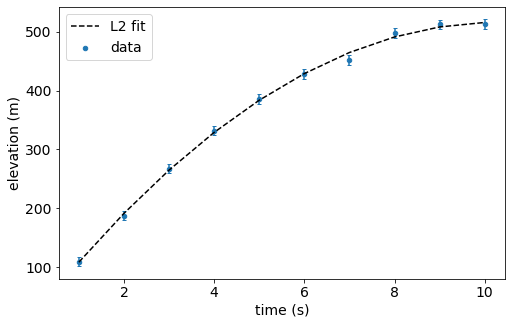

In [60]:
#-- data (first and second column represent time and position respectively ---
data = np.array([[1, 109.4], [2, 187.5], [3, 267.5], [4, 331.9], [5, 386.1], [6, 428.4], \
             [7, 452.2], [8, 498.1], [9, 512.3], [10, 513.0]]) 

nObs = data.shape[0] # no. of observations
nParams = 3 # no. of parameters

mean, sigma = 0, 8  # normal data errors

#-- model matrix ---
G = np.ones((nObs, 3))
G[:,1] = G[:,1] * data[:,0]
G[:,2] = - G[:,2] * data[:,0]**2 / 2

L2_sol = getL2Sol(data[:,1], G)

#-- model prediction with L2 solution ---
model_L2 = L2_sol[0] + L2_sol[1]*data[:,0] - 0.5 * L2_sol[2] * data[:,0]**2

#-- covariance matric --
CovMat_L2 = sigma**2 * np.linalg.inv(np.matmul(np.transpose(G), G))
Var = np.diag(CovMat_L2)

#-- correlation matrix
CorrelMat_L2 = np.zeros((nParams, nParams))

for i in range(nParams):
    for j in range(nParams):
        CorrelMat_L2[i,j] = CovMat_L2[i,j]/np.sqrt(Var[i]*Var[j])

print('Covariance matrix')
print(CovMat_L2)
print('\n')
 
print('Correlation matrix')
print(CorrelMat_L2)
print('\n')

print('L2 solution with 95% CI')

for i in range(nParams):
    
    print('m{} = {} +- {}'.format(i+1, L2_sol[i], 1.96*np.sqrt(np.diag(CovMat_L2)[i])))

print('\n')

#-- chisquare statistic ---
chisq_obs = np.sum((data[:,1] - np.matmul(G, L2_sol.reshape(nParams,1)).flatten())**2 / sigma**2)
print('chisq_obs = {}'.format(chisq_obs))
print('p-value: {}'.format(1 - chi2(nObs-nParams).cdf(chisq_obs)))

#-- plotting the data with model prediction ---
plt.figure(figsize=(8,5))

plt.scatter(data[:,0], data[:,1], label='data', s=20)
plt.errorbar(data[:,0], data[:,1], yerr = sigma, capsize=2, ls='None')
plt.plot(data[:,0], model_L2, ls='--', c='k', label='L2 fit')
plt.xlabel('time (s)', fontsize=14)
plt.ylabel('elevation (m)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [61]:
def contour(CovMat, Deltasq):
    
    """
    Function to generate contour for a given confidence interval
    
    Parameters
    -----------
    CovMat: covariance matrix (numpy array)
    Deltasq: ppf value chi2 distribution for a given percentile
    
    Returns
    --------
    r: contour (xi: r[:,i])
    
    """
    
    theta = np.linspace(0, 2*np.pi, 10000)
    xhat = np.column_stack((np.cos(theta), np.sin(theta)))
    
    CInv = np.linalg.inv(CovMat)
    
    r = np.zeros((N, CovMat.shape[0]))
    
    for i in range(N):
        
        r[i,:] = np.sqrt(Deltasq/(np.matmul(np.matmul(xhat[i,:].reshape(1,2), CInv), 
                                          xhat[i,:].reshape(1,2).T)))*xhat[i,:]
    return r

In [62]:
N = 10000
pcentle = 0.95 # percentile
df = nObs - nParams # degrees of freedom
Deltasq = chi2.ppf(pcentle, df) # ppf value
vals = contour(CovMat_L2[0:2, 0:2], Deltasq) # contour calculation

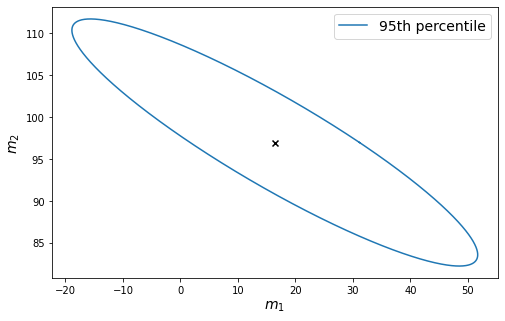

In [63]:
plt.figure(figsize=(8, 5))

plt.plot(vals[:,0] + L2_sol[0], vals[:,1] + L2_sol[1], label='95th percentile')
plt.scatter(L2_sol[0], L2_sol[1], marker='x', c='k')
plt.xlabel(r'$m_1$', fontsize=14)
plt.ylabel(r'$m_2$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### $\chi^2$ test

In [64]:
seed = 1
np.random.seed(seed)

nRealzns = 1000
noise_realzns = sigma*np.random.randn(data.shape[0], nRealzns)
data_realzns = np.zeros((data.shape[0], nRealzns))
chisq = np.zeros(nRealzns)

#-- making different data realizations --
for i in range(nRealzns):
    
    data_realzns[:,i] = model_L2 + noise_realzns[:,i]

#-- calculating chisquare for each realization --    
for j in range(nRealzns):
    
    chisq[j] = np.sum((data_realzns[:,j] - np.matmul(G, \
                        getL2Sol(data_realzns[:,j], G).reshape(nParams,1)).flatten())**2 / sigma**2)
    

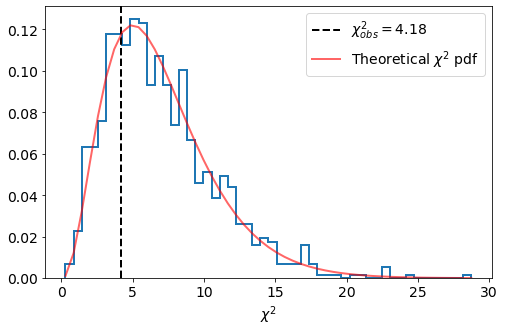

In [65]:
plt.figure(figsize=(8,5))

_, bins, _ = plt.hist(chisq, bins=50, histtype='step', lw=2, density=True)
plt.axvline(x=chisq_obs, ls='--', c='k', lw=2, label=r'$\chi_{obs}^2 = %.2f$'%chisq_obs)
plt.plot(bins, chi2.pdf(bins, nObs-nParams),
                           'r-', lw=2, alpha=0.6, label=r'Theoretical $\chi^2$ pdf')

plt.xlabel(r'$\chi^2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Testing ML2 solution with one outlier in data

L2 solution
m1 = -135.2116666666568
m2 = 195.7540151515122
m3 = 32.381060606060124


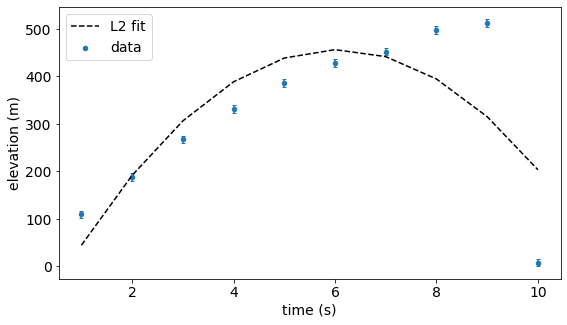

In [66]:
#-- data ---
data_outlr = np.array([[1, 109.4], [2, 187.5], [3, 267.5], [4, 331.9], [5, 386.1], [6, 428.4], \
             [7, 452.2], [8, 498.1], [9, 512.3], [10, 7.6]])

#-- model matrix ---
G = np.ones((nObs, nParams))
G[:,1] = G[:,1] * data_outlr[:,0]
G[:,2] = - G[:,2] * data_outlr[:,0]**2 / 2

#-- L2 Solution ---
L2_sol_outlr = getL2Sol(data_outlr[:,1], G)

print('L2 solution')
print('m1 = {}'.format(L2_sol_outlr[0]))
print('m2 = {}'.format(L2_sol_outlr[1]))
print('m3 = {}'.format(L2_sol_outlr[2]))

#-- model prediction with ML2 solution ---
model_outlr_L2 = L2_sol_outlr[0] + L2_sol_outlr[1]*data_outlr[:,0] \
                            - 0.5 * L2_sol_outlr[2]*data_outlr[:,0]**2

#-- plotting the data with model prediction ---
plt.figure(figsize=(9,5))

plt.scatter(data_outlr[:,0], data_outlr[:,1], label='data', s=20)
plt.errorbar(data_outlr[:,0], data_outlr[:,1], yerr = sigma, capsize=2, ls='None')
plt.plot(data_outlr[:,0], model_outlr_L2, ls='--', c='k', label='L2 fit')
plt.xlabel('time (s)', fontsize=14)
plt.ylabel('elevation (m)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

#### Conclusion 
ML2 solution is not robust against even one outlier in the data 

### ML1 Solution

$$G^T RG\,m = G^{T}R \,\vec d$$

#### Iterative reweighted least square (IRLS) algorithm

We start with $m^{(0)} = m_{L2}$ solution and calculate the corresponding residual vector $r^{(0)} = d - Gm^{(0)}$ to construct the weighting matrix $R$, where $R_{i,i} = \frac{1}{|r_i|}$. We then solve the above equation to obtain a new model $m^{(1)}$ and associated residual vector $r^{(1)}$. The process is repeated until the model and residual vectors converge. A typical rule is to stop the iteration when 

$$\frac{||m^{(k+1)} - m^{(k)}||_{2}}{1+||m^{(k+1)}||_2} < \tau $$

for a specified tolerance $\tau$.

In [67]:
tol = 10**(-5)
L1_solution = getL1Sol(data[:,1], G, L2_sol_outlr, tol)

#-- model prediction with L1 solution ---
model_L1 = L1_solution[0] + L1_solution[1]*data_outlr[:,0] \
                                - 0.5 * L1_solution[2] * data_outlr[:,0]**2


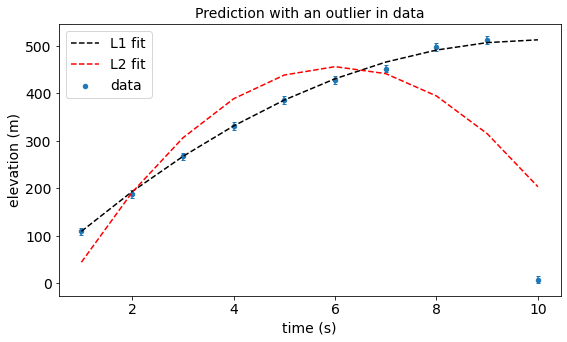

In [68]:
#-- plotting the data with model prediction ---
plt.figure(figsize=(9,5))

plt.scatter(data_outlr[:,0], data_outlr[:,1], label='data', s=20)
plt.errorbar(data_outlr[:,0], data_outlr[:,1], yerr = sigma, capsize=2, ls='None')
plt.plot(data_outlr[:,0], model_L1, ls='--', c='k', label='L1 fit')
plt.plot(data_outlr[:,0], model_outlr_L2, ls='--', c='r', label='L2 fit')
plt.xlabel('time (s)', fontsize=14)
plt.ylabel('elevation (m)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=2, fontsize=14)
plt.title('Prediction with an outlier in data', fontsize=14)
plt.show()

#### Conclusion 
ML1 solution is robust against outliers in the data as compared to ML2 solution.

#### Covariance matrix calculation

In [71]:
seed = 0
np.random.seed(seed)

nRealzns = 1000
noise_realzns = np.random.randn(data.shape[0], nRealzns)
data_realzns = np.zeros((data.shape[0], nRealzns))

#-- making different data realizations --
for i in range(nRealzns):
    
    data_realzns[:,i] = model_L1 + noise_realzns[:,i] 

A = np.zeros((nRealzns, nParams))

for i in range(nRealzns):
    
    mL1_temp = getL1Sol(data_realzns[:,i], G, L1_solution, tol)
    A[i,:] = mL1_temp - L1_solution

#-- covariance matric --
CovMat = np.matmul(A.T, A)/nRealzns

print('Covariance matrix')
print(CovMat)
print('\n')
print('L1 solution with 95% CI')

for i in range(nParams):
    
    print('m{} = {} +- {}'.format(i+1, L1_solution[i], 1.96*np.sqrt(np.diag(CovMat)[i])))

print('\n')

Covariance matrix
[[ 1.7689825  -0.66417127 -0.10496009]
 [-0.66417127  0.31197202  0.05455183]
 [-0.10496009  0.05455183  0.01010392]]


L1 solution with 95% CI
m1 = 15.895908905470137 +- 2.6068607909420685
m2 = 98.36990790720465 +- 1.0947473296801153
m3 = 9.731633630852322 +- 0.19701581654809683


